# CNN for CIFAR10 with Tensorflow 2

This program trains a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR-10 images](https://www.cs.toronto.edu/~kriz/cifar.html). It uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow, and [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), therefore creating and training the model will not take many lines of code.

### Install required packages

In [1]:
# Uncomment and run only once, the packages will remain.
# Restart the kernel for installed packages to work.
# pip install scikit-learn
# pip install mlxtend

### Import TensorFlow and other libraries

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf

# Python standard library
import math

# Helper libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.utils import shuffle
from mlxtend.plotting import plot_confusion_matrix

print(tf.__version__)

2.4.1


### Define functions

In [3]:
# calculate the softmax of a vector
# in order to convert vector of outputs
# to vector of probabilities
def softmax(vector):
    e = np.exp(vector)
    return e / e.sum()

### Download and prepare the CIFAR-10 dataset


The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [4]:
# Import and load the CIFAR-10 data directly from tf.keras
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The images are 32x32 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of arrays containing an integer, ranging from 0 to 9. These correspond to the *class* the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Airplane</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Automobile</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Bird</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Cat</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Deer</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Dog</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Frog</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Horse</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Ship</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Truck</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [5]:
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

### Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 50,000 images in the training set, with each image represented as 32 x 32 pixels:

In [6]:
train_images.shape

(50000, 32, 32, 3)

Likewise, there are 50,000 labels in the training set:

In [7]:
len(train_labels)

50000

Each label is an array containing an integer between 0 and 9


In [8]:
test_labels

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

There are 10,000 images in the test set. Again, each image is represented as 32 x 32 pixels:

In [9]:
test_images.shape

(10000, 32, 32, 3)

And the test set contains 10,000 images labels:

In [10]:
len(test_labels)

10000

### Choose  a custom ratio between training and testing data

First, we shuffle the data randomly:

In [11]:
all_images = np.concatenate((train_images, test_images))
all_labels = np.concatenate((train_labels, test_labels))

all_images, all_labels = shuffle(train_images, train_labels, random_state=0)

Then, we choose the ratio of test and train data:

In [12]:
# choose the percentage of test images
test_images_percentage = 10

train_images_percentage = 100 - test_images_percentage
train_images_count = math.ceil(len(all_images)*(train_images_percentage/100))

train_images, test_images = np.split(all_images, [train_images_count])
train_labels, test_labels = np.split(all_labels, [train_images_count])

print("train images:", train_images.shape)
print("test images:", test_images.shape)

train images: (45000, 32, 32, 3)
test images: (5000, 32, 32, 3)


### Preprocess the data

The data must be preprocessed before training the network. If we inspect the first image in the training set, we will see that the pixel values fall in the range of 0 to 255:

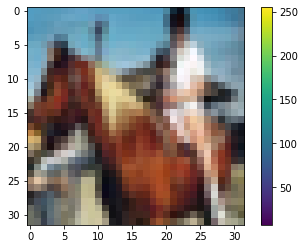

In [13]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale (normalize) these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way:

In [14]:
train_images, test_images = train_images / 255.0, test_images / 255.0

### Verify the data

To verify that the data is in the correct format and that we're ready to build and train the network, let's display the first 25 images from the training set and display the class name below each image.

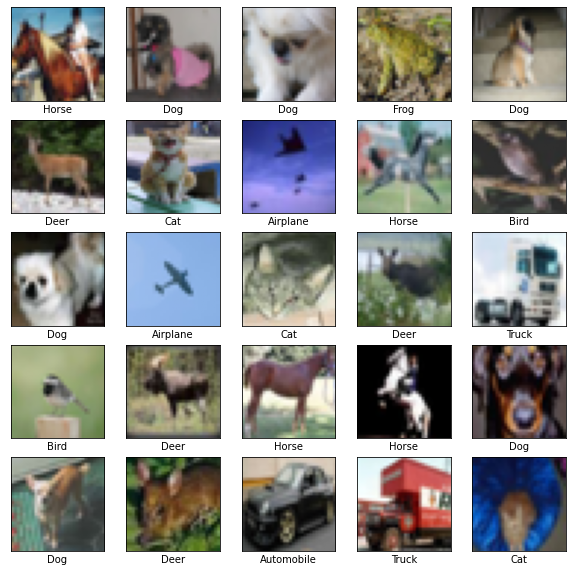

In [15]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up architecture

The basic building block of a neural network is the [*layer*](https://www.tensorflow.org/api_docs/python/tf/keras/layers). Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers have parameters that are learned during training.

We use the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview) to create the model.

In [16]:
model = tf.keras.Sequential()

#### Create the convolutional base

The lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. color_channels refers to (R,G,B). We will configure our CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images.  This can be done by passing the argument `input_shape` to our first layer.

In [17]:
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of our model so far.

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


Above, we can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as we go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically, as the width and height shrink, we can afford (computationally) to add more output channels in each Conv2D layer.

#### Add Dense layers on top

To complete our model, we will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor.

First, we will flatten (or unroll) the 3D output to 1D. The layer `tf.keras.layers.Flatten` transforms the format of the images from a 3D arrays containing two-dimensional arrays (of 32 by 32 pixels) to a one-dimensional array (of 32 * 32 = 1024 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 64 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes of the CIFAR-10 dataset.


In [19]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10))

Here's the complete architecture of our model.

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

We can see that our (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

#### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's [*compile*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) step:

* [*Loss function*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) —This measures how accurate the model is during training. We want to minimize this function to "steer" the model in the right direction.
* [*Optimizer*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) —This is how the model is updated based on the data it sees and its loss function.
* [*Metrics*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) —Used to monitor the training and testing steps. We use *accuracy*, the fraction of the images that are correctly classified.

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

Training the neural network model requires the following steps:

1. Feeding the training data to the model. In this case, the training data is in the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. We ask the model to make predictions about a test set—in this case, the `test_images` array.
4. Verify that the predictions match the labels from the `test_labels` array.


### Feed the model

To start training, we call the [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method—so called because it "fits" the model to the training data. We also pass testing data as `validation_data` parameter on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data.

In [22]:
epoch_count = 20
history = model.fit(train_images, train_labels, batch_size=32, epochs=epoch_count, validation_data=(test_images, test_labels))

Epoch 1/20
1407/1407 [==============================] - 8s 4ms/step - loss: 1.7949 - accuracy: 0.3367 - val_loss: 1.3040 - val_accuracy: 0.5338
Epoch 2/20
1407/1407 [==============================] - 5s 4ms/step - loss: 1.2203 - accuracy: 0.5672 - val_loss: 1.1536 - val_accuracy: 0.5994
Epoch 3/20
1407/1407 [==============================] - 5s 4ms/step - loss: 1.0412 - accuracy: 0.6323 - val_loss: 1.0006 - val_accuracy: 0.6562
Epoch 4/20
1407/1407 [==============================] - 5s 4ms/step - loss: 0.9315 - accuracy: 0.6689 - val_loss: 0.9681 - val_accuracy: 0.6726
Epoch 5/20
1407/1407 [==============================] - 5s 4ms/step - loss: 0.8426 - accuracy: 0.7054 - val_loss: 0.9911 - val_accuracy: 0.6654
Epoch 6/20
1407/1407 [==============================] - 5s 4ms/step - loss: 0.7859 - accuracy: 0.7232 - val_loss: 0.8920 - val_accuracy: 0.6866
Epoch 7/20
1407/1407 [==============================] - 5s 4ms/step - loss: 0.7262 - accuracy: 0.7451 - val_loss: 0.9823 - val_accuracy:

As the model trains, the loss and accuracy metrics are displayed (as well as the loss and accuracy of testing  data ("val_accuracy" here). This model reaches an accuracy of about 0.89 (or 89%) on the training data.

### Evaluate the model

Next, compare how the model performs on the test dataset:

In [24]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

157/157 - 0s - loss: 1.1794 - accuracy: 0.6972

Test accuracy: 0.6972000002861023


It turns out that the accuracy on the test dataset is less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents *overfitting*. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data. For more information, see the following:
*   [Demonstrate overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)
*   [Strategies to prevent overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting)

We can also plot the graph of the accuracy of both training and testing data, which changes after every epoch.

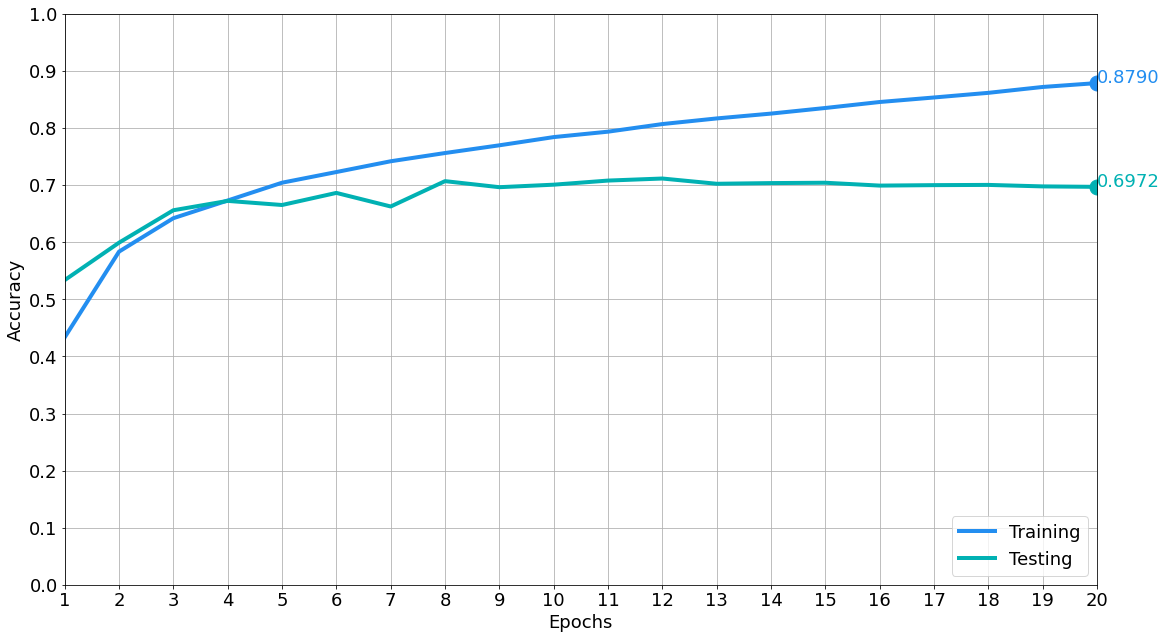

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

ax.xaxis.set_ticks(np.arange(0, epoch_count+1))
ax.yaxis.set_ticks(np.arange(0, 1.1, 0.1))
ax.grid()

train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

color_train='#238ef0'
color_test='#01b1b3'

plt.rcParams.update({'font.size': 18})
plt.plot(np.arange(1,epoch_count+1), train_acc, label='Training', c=color_train, linewidth=4)
plt.plot(np.arange(1,epoch_count+1), test_acc, label='Testing', c=color_test, linewidth=4)

plt.plot(epoch_count, train_acc[-1],'co', c=color_train, markersize=15)
plt.text(epoch_count, train_acc[-1], "{:.4f}".format(train_acc[-1]), c=color_train)

plt.plot(epoch_count, test_acc[-1], 'co', c=color_test, markersize=15)
plt.text(epoch_count, test_acc[-1], "{:.4f}".format(test_acc[-1]), c=color_test)

plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)

plt.xlim([1, epoch_count])
plt.ylim([0.0, 1.0])

plt.legend(loc='lower right')

Classification report and a confusion matrix can also be generated:


Classification Report: 

               precision    recall  f1-score   support

           0       0.68      0.77      0.72       501
           1       0.80      0.88      0.84       512
           2       0.56      0.59      0.57       532
           3       0.51      0.46      0.49       487
           4       0.76      0.57      0.65       497
           5       0.63      0.57      0.60       509
           6       0.72      0.80      0.76       471
           7       0.69      0.76      0.72       485
           8       0.86      0.77      0.81       528
           9       0.76      0.80      0.78       478

    accuracy                           0.70      5000
   macro avg       0.70      0.70      0.69      5000
weighted avg       0.70      0.70      0.69      5000



Confusion Matrix:


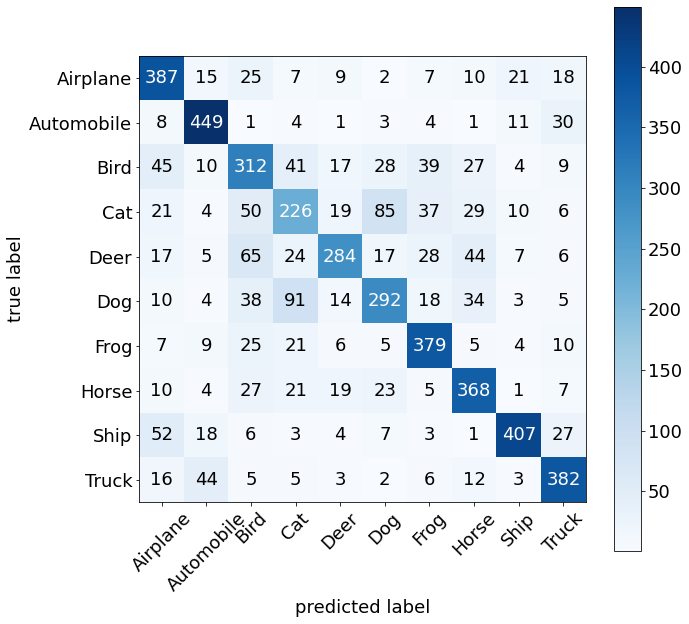

In [27]:
predicted_test_images = model.predict(test_images)
predicted_test_image_classes = [np.argmax(element) for element in predicted_test_images]

print("\nClassification Report: \n\n",
      classification_report(test_labels, predicted_test_image_classes))

cmat_multiclass = confusion_matrix(test_labels, predicted_test_image_classes)

print("\n\nConfusion Matrix:")

fig, ax = plot_confusion_matrix(conf_mat=cmat_multiclass,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=False,
                                class_names=class_names,
                                figsize=(10,10))

plt.show()

Our simple CNN has achieved a test accuracy of 69%. For another CNN style, we could use the Keras subclassing API and a `tf.GradientTape`. For that, see instructions [here](https://www.tensorflow.org/tutorials/quickstart/advanced).

There is also a version of this program with changeable parameters and network architecture for further testing and model refinement.

### Show classification results of some images

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


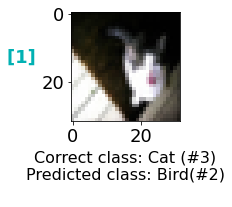

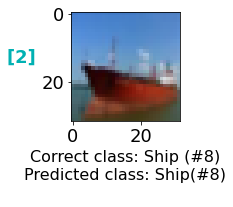

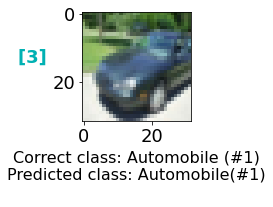

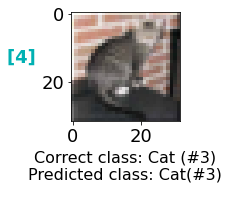

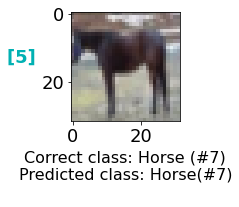

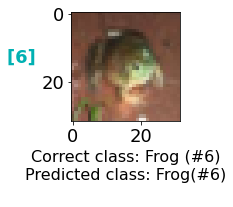

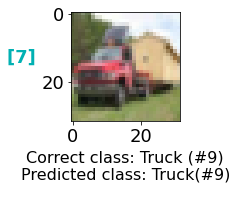

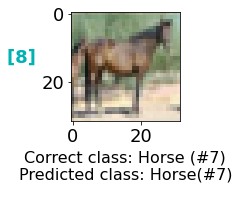

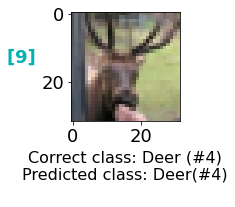

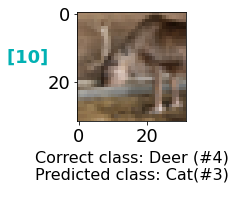

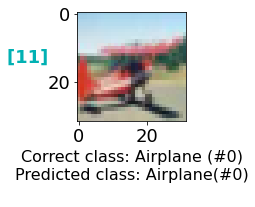

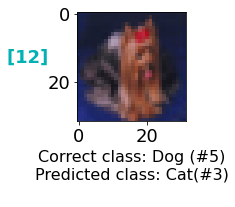

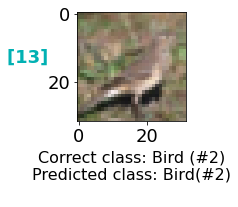

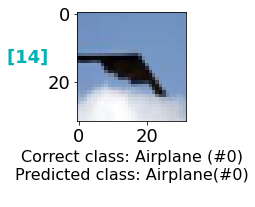

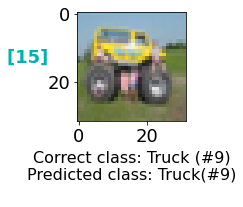

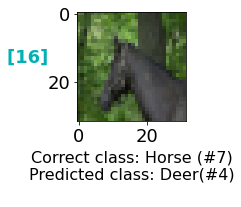

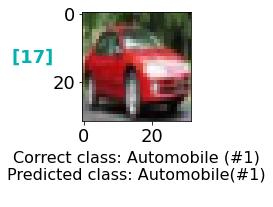

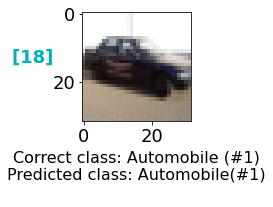

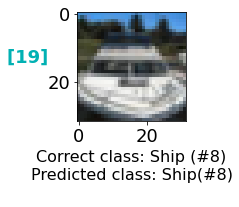

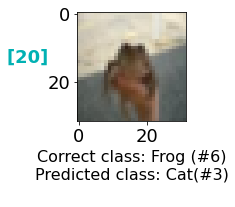

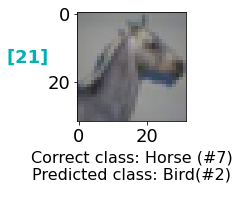

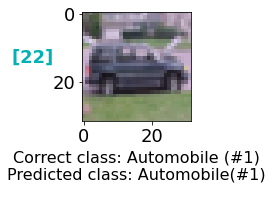

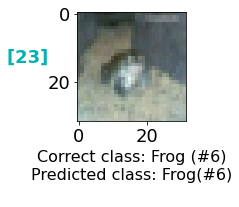

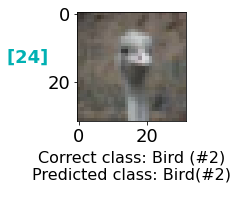

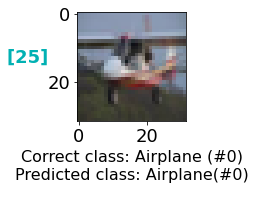

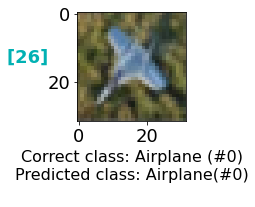

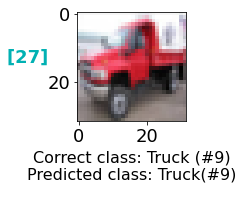

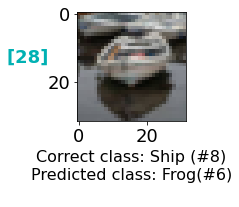

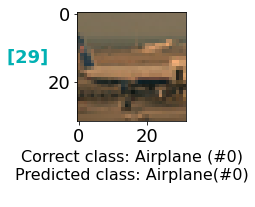

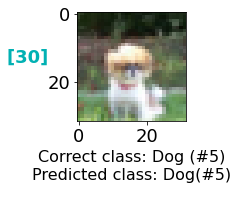

In [28]:
 # select how many images to present
sample_img_count = 30

test_image_predictions = model.predict(test_images[:sample_img_count])
#print(test_image_predictions)

# convert vectors of outputs to vectors of probabilities
test_image_predictions = [softmax(x) for x in test_image_predictions]

# get the classes our CNN predicted
predicted_classes = [np.argmax(element) for element in test_image_predictions]

# get the correct classes
correct_classes = list(test_labels[:sample_img_count].reshape(-1,))

for i in range(sample_img_count):
    ylabel = f'[{i+1}]'
    
    plt.figure(figsize = (15,2))
    plt.imshow(test_images[i])

    xlabel = (
        f'Correct class: {class_names[correct_classes[i]]} (#{correct_classes[i]})\n'
        f'Predicted class: {class_names[predicted_classes[i]]}(#{predicted_classes[i]})\n'
    )
    ylabel = f'[{i+1}]     '
        
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=18, fontweight='bold', color='#01b1b3', rotation=0)

#### The classification probabilites for each class can also be printed for every image:

In [29]:
print('\nOutput probabilities:\n ')

for i in range(sample_img_count):
    print(f'[{i+1}]:\n')

    np.set_printoptions(precision=4, suppress=True)
    print(test_image_predictions[i])
    np.set_printoptions()
    print('\n\n')


Output probabilities:
 
[1]:

[0.1764 0.     0.3751 0.1302 0.0001 0.0515 0.0052 0.0012 0.2603 0.    ]



[2]:

[0.     0.     0.     0.     0.0007 0.     0.     0.     0.9993 0.    ]



[3]:

[0.     0.9925 0.     0.     0.     0.     0.     0.     0.     0.0075]



[4]:

[0.     0.     0.     0.7589 0.0013 0.0004 0.2085 0.0309 0.     0.    ]



[5]:

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]



[6]:

[0.     0.     0.0001 0.0502 0.     0.0003 0.9494 0.     0.     0.    ]



[7]:

[0.0335 0.0688 0.0003 0.     0.     0.0007 0.     0.0009 0.     0.8958]



[8]:

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]



[9]:

[0.0117 0.     0.     0.     0.9883 0.     0.     0.     0.     0.    ]



[10]:

[0.0001 0.     0.0792 0.6487 0.2107 0.0364 0.0245 0.0005 0.     0.    ]



[11]:

[0.488  0.0016 0.0004 0.0027 0.0002 0.     0.     0.2907 0.0062 0.2102]



[12]:

[0.     0.     0.0041 0.7103 0.0002 0.2605 0.0062 0.0188 0.     0.    ]



[13]:

[0.0001 0.0001 0.9037 0.     0.0009 0.     0.0951 0.     0.0001 0.    ]

